In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import pandas as pd
from tensorflow.keras.backend import sigmoid
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def swish(x, beta = 1):
    # https://www.geeksforgeeks.org/ml-swish-function-by-google-in-keras/
    return (x * sigmoid(beta * x))
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.25)
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
def weighted_loss(y_true, y_pred):
    return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)

get_custom_objects().update({'swish': swish})
get_custom_objects().update({'leaky_relu': leaky_relu})
get_custom_objects().update({"get_weighted_loss": get_weighted_loss})
get_custom_objects().update({"weighted_loss": weighted_loss})

In [6]:
banana_X_train = pd.read_pickle("veg_X_train.pkl")
banana_X_val = pd.read_pickle("veg_X_val.pkl")
banana_Y_train = pd.read_pickle("veg_Y_train.pkl")
banana_Y_val = pd.read_pickle("veg_Y_val.pkl")
cols_name = [[y+'-'+str(x).rjust(2,"0") for x in range(1,31)] for y in ['RSV','上價中位數','下價中位數','中價中位數','交易量','平均價','雨量']]
cols_name_2 = [x for x in banana_X_train.columns.tolist() if '-' not in x]

train_X_num = banana_X_train[cols_name_2[1:]].values
val_X_num = banana_X_val[cols_name_2[1:]].values

train_Y_1 = banana_Y_train[[x for x in banana_Y_train.columns if '成本價格' in x]].values
val_Y_1 = banana_Y_val[[x for x in banana_Y_val.columns if '成本價格' in x]].values

train_X_lstm_1 = []
for i in range(len(cols_name)):
    tmp = banana_X_train[cols_name[i]].iloc[:,-7:]
    train_X_lstm_1.append(tmp)
train_X_lstm_1 = np.stack(train_X_lstm_1,axis=2)
val_X_lstm_1 = []
for i in range(len(cols_name)):
    tmp = banana_X_val[cols_name[i]].iloc[:,-7:]
    val_X_lstm_1.append(tmp)
val_X_lstm_1 = np.stack(val_X_lstm_1,axis=2)

train_X_lstm_2 = []
for i in range(len(cols_name)):
    tmp_all = []
    tmp = banana_X_train[cols_name[i]].iloc[:,-13:]
    for j in range(7):
        tmp_1 = tmp.iloc[:,j:j+7]
        tmp_all.append(tmp_1)
    tmp_all = np.stack(tmp_all,axis=2)
    train_X_lstm_2.append(tmp_all)
train_X_lstm_2 = np.stack(train_X_lstm_2,axis=3)

val_X_lstm_2 = []
for i in range(len(cols_name)):
    tmp_all = []
    tmp = banana_X_val[cols_name[i]].iloc[:,-13:]
    for j in range(7):
        tmp_1 = tmp.iloc[:,j:j+7]
        tmp_all.append(tmp_1)
    tmp_all = np.stack(tmp_all,axis=2)
    val_X_lstm_2.append(tmp_all)
val_X_lstm_2 = np.stack(val_X_lstm_2,axis=3)

train_X_lstm_4 = np.stack([np.stack([image_convert(x) for x in banana_X_train[cols_name[y]].values]) for y in range(len(cols_name))], axis=3)
val_X_lstm_4 = np.stack([np.stack([image_convert(x) for x in banana_X_val[cols_name[y]].values]) for y in range(len(cols_name))], axis=3)

data_X = {'Conv1D':[train_X_lstm_1, val_X_lstm_1],
          'Vanilla':[train_X_lstm_1, val_X_lstm_1],
          'Stacked':[train_X_lstm_1, val_X_lstm_1],
          'Bidirectional':[train_X_lstm_1, val_X_lstm_1],
          'Conv1D_LSTM':[train_X_lstm_2, val_X_lstm_2],
          'Conv2D_1':[train_X_lstm_2, val_X_lstm_2],
          'Conv2D_2':[train_X_lstm_4, val_X_lstm_4]}

In [5]:
weight = 'model/Conv1D_LSTM/0-sgd-relu-relu/weights_accuracy.hdf5'
model = load_model(weight)
data_train = model.predict([data_X["Conv1D_LSTM"][1],val_X_num], verbose = 0)

before = banana_Y_val[['成本價格-02', '成本價格-03', '成本價格-04', '成本價格-05', '成本價格-06']].values
after = data_train

2022-09-29 10:28:31.366360: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1cacb940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-09-29 10:28:31.366439: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-09-29 10:28:31.382533: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-09-29 10:28:32.140915: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-09-29 10:28:33.199443: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


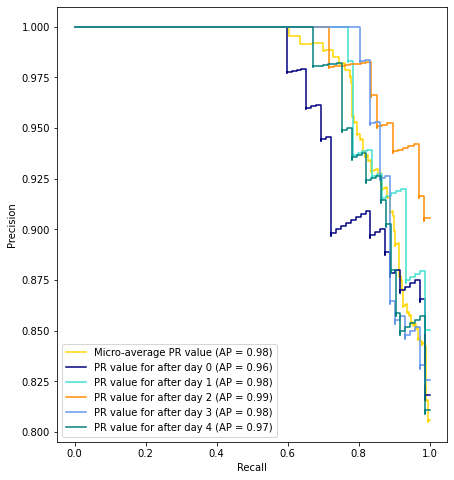

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from itertools import cycle
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(7, 8))

# For each class
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

precision = dict()
recall = dict()
average_precision = dict()
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(before[:, i], after[:, i])
    average_precision[i] = average_precision_score(before[:, i], after[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    before.ravel(), after.ravel()
)
average_precision["micro"] = average_precision_score(before, after, average="micro")

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average PR value", color="gold")

for i, color in zip(range(5), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"PR value for after day {i}", color=color)

In [1]:
#!pip install ipywidgets
import shap
import tensorflow as tf
tf.keras.backend.set_learning_phase(True)
from tensorflow.keras.models import load_model

2022-09-29 11:28:33.698158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 11:28:33.939417: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 11:28:40.118538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-09-29 11:28:40.118669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Coul

In [7]:
weight = 'model/Conv1D_LSTM/0-sgd-relu-relu/weights_accuracy.hdf5'
model = load_model(weight,compile=False)
explainer = shap.DeepExplainer(model, [data_X["Conv1D_LSTM"][0],train_X_num], learning_phase_flags = None)
a = explainer.shap_values([data_X["Conv1D_LSTM"][0][0:1,:,:,:],train_X_num[0:1,:]])


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
2022-09-29 11:29:55.107446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    File "/home/jack155861/.local/lib/python3.8/site-packages/shap/explainers/_deep/deep_tf.py", line 252, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


In [8]:
explainer = shap.DeepExplainer(model, [data_X["Conv1D_LSTM"][0][0:2,:,:,:],train_X_num[0:2,:]], learning_phase_flags = None)
#explainer = shap.KernelExplainer(simple_model_only_first_output, [data_X["Conv1D_LSTM"][0],train_X_num])

In [9]:
explainer.shap_values([data_X["Conv1D_LSTM"][0][0:2,:,:,:],train_X_num[0:2,:]])

StagingError: in user code:

    File "/home/jack155861/.local/lib/python3.8/site-packages/shap/explainers/_deep/deep_tf.py", line 252, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


In [20]:
model.outputs

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_3')>]

In [25]:


explainer = shap.Explainer(model)
#explainer = shap.explainers.Permutation(model, max_evals = 2671971)

shap_values = explainer([data_X["Conv1D_LSTM"][1][:5],val_X_num[:5].reshape((5,21))], max_evals = 50000)
# visualize the first prediction's explanation

shap.plots.waterfall(shap_values[0])

TypeError: 'NoneType' object is not callable

TypeError: Tensors are unhashable (this tensor: KerasTensor(type_spec=TensorSpec(shape=(?, 7, 7, 7), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")). Instead, use tensor.ref() as the key.

In [ ]:


shap_values = explainer.shap_values([data_X["Conv1D_LSTM"][1],val_X_num])

In [35]:
explainer = shap.DeepExplainer(model, [data_X["Conv1D_LSTM"][0],train_X_num])
#shap_values = explainer.shap_values([data_X["Conv1D_LSTM"][1][:5],val_X_num[:5]])

In [33]:
shap.Explainer.

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 7, 7)]    0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 7, 7, 64)    960         ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 7, 7, 64)    256         ['time_distributed[0][0]']       
 buted)                                                                                           
                                                                                              

In [18]:
clustering = shap.utils.hclust(X.values, y)

In [17]:
clustering

array([[ 3.        ,  5.        ,  0.03998143,  2.        ],
       [ 7.        , 12.        ,  0.57783765,  3.        ],
       [ 1.        ,  4.        ,  0.61038065,  2.        ],
       [ 2.        , 14.        ,  0.64025795,  3.        ],
       [ 0.        , 13.        ,  0.65362942,  4.        ],
       [15.        , 16.        ,  0.82917935,  7.        ],
       [11.        , 17.        ,  0.85548913,  8.        ],
       [10.        , 18.        ,  0.87416458,  9.        ],
       [ 8.        , 19.        ,  0.95298803, 10.        ],
       [ 9.        , 20.        ,  0.97237563, 11.        ],
       [ 6.        , 21.        ,  0.97623998, 12.        ]])

In [23]:
X.shape

(32561, 12)

In [13]:
# build a clustering of the features based on shared information about y
clustering = shap.utils.hclust([data_X["Conv1D_LSTM"][1],val_X_num], val_Y_1)
# above we implicitly used shap.maskers.Independent by passing a raw dataframe as the masker
# now we explicitly use a Partition masker that uses the clustering we just computed
masker = shap.maskers.Partition(data_X["Conv1D_LSTM"][1], clustering=clustering)

# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(model, masker)
#shap_values2 = explainer(X[:100])

# get just the explanations for the positive class
#shap_values2 = shap_values2[...,1]

ValueError: Found input variables with inconsistent numbers of samples: [2, 688]

In [ ]:
model.p